In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [9]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

device(type='cuda')

# ResNext

**Problems with ResNets:**
One of the challenges one encounters in the design of ResNet is the trade-off between nonlinearity and dimensionality within a given block. That is, we could add more nonlinearity by increasing the number of layers, or by increasing the width of the convolutions. An alternative strategy is to increase the number of channels that can carry information between blocks

Unfortunately, the latter comes with a quadratic penalty since the computational cost of ingesting `ci` channels and emitting `co` channels is proportional to `O(ci*co)`  


To Solve this we can take inspiration from `Inception-Block` for *GoogLeNet*

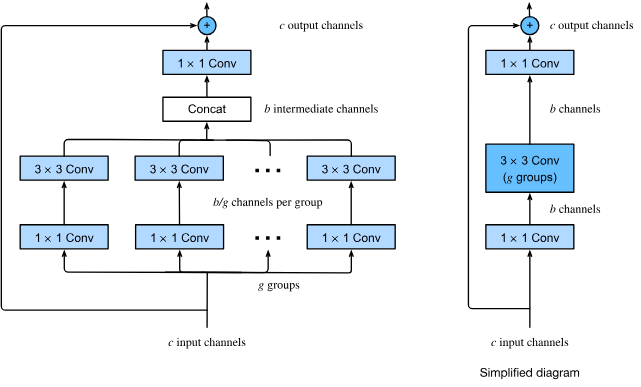

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs) -> None:
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels, eps=1e-3, momentum=0.01)
        )

    def forward(self, X):
        return self.conv_block(X)


class ResNeXtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups, use_1x1_conv=False) -> None:
      super().__init__()
      assert out_channels % groups == 0, f"out_channels:{out_channels} can't be divided into groups:{groups}"

      self.group = nn.Sequential(
          ConvBlock(in_channels, out_channels, 1, padding='same'),
          ConvBlock(out_channels, out_channels, 3,padding='same', groups=groups)
      )

      self.conv_1x1 = None
      if use_1x1_conv:
          self.conv_1x1 = ConvBlock(
            in_channels, out_channels, 1, padding='same')

    def forward(self, X):
        out = self.group(X)
        if self.conv_1x1:
            X = self.conv_1x1(X)
        return X+out

In [5]:
from typing import Union, Tuple, List


class ResNext(nn.Module):
    def __init__(self, in_channels: int, num_classes: int, hidden_dims: Union[Tuple, List], groups: Union[List, Tuple]):
        super().__init__()
        feature_extractor = [ConvBlock(in_channels, 16, 7)]
        in_channels = 16
        for i in range(len(hidden_dims)-1):
            feature_extractor.extend((ResNeXtBlock(
                in_channels, hidden_dims[i], groups[i], use_1x1_conv=True), nn.MaxPool2d(2, 2)))
            in_channels = hidden_dims[i]

        self.feature_extractor = nn.Sequential(*feature_extractor)

        self.flatten = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(inplace=True),
            nn.LazyLinear(num_classes)
        )

    def forward(self, X):
        out = self.feature_extractor(X)
        out = self.flatten(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [25]:
model = ResNext(3, 10, [64, 128, 256, 512], [4, 8, 16, 32]).to(DEVICE)

In [11]:
model

ResNext(
  (feature_extractor): Sequential(
    (0): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
    (1): ResNeXtBlock(
      (group): Sequential(
        (0): ConvBlock(
          (conv_block): Sequential(
            (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
            (1): LeakyReLU(negative_slope=0.01)
            (2): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
        (1): ConvBlock(
          (conv_block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=4)
            (1): LeakyReLU(negative_slope=0.01)
            (2): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
    

In [13]:
from torchsummary import summary
summary(model,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]           2,368
         LeakyReLU-2           [-1, 16, 58, 58]               0
       BatchNorm2d-3           [-1, 16, 58, 58]              32
         ConvBlock-4           [-1, 16, 58, 58]               0
            Conv2d-5           [-1, 64, 58, 58]           1,088
         LeakyReLU-6           [-1, 64, 58, 58]               0
       BatchNorm2d-7           [-1, 64, 58, 58]             128
         ConvBlock-8           [-1, 64, 58, 58]               0
            Conv2d-9           [-1, 64, 58, 58]           9,280
        LeakyReLU-10           [-1, 64, 58, 58]               0
      BatchNorm2d-11           [-1, 64, 58, 58]             128
        ConvBlock-12           [-1, 64, 58, 58]               0
           Conv2d-13           [-1, 64, 58, 58]           1,088
        LeakyReLU-14           [-1, 64,

## Training

In [14]:
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torchvision import transforms as T
from torchvision.datasets import CIFAR10

In [15]:
MEAN,STD=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transforms=T.Compose([
    T.ToTensor(),
    T.Resize((64,64)),
    T.Normalize(MEAN,STD)  # Normalize with mean and std
])

train_ds=CIFAR10(root="./data",download=True,train=True,transform=transforms)
val_ds=CIFAR10(root="./data",download=False,train=False,transform=transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 12574917.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [16]:
train_dl=DataLoader(train_ds,batch_size=64,shuffle=True,pin_memory=True,num_workers=2)
val_dl=DataLoader(val_ds,batch_size=128,shuffle=False,pin_memory=True,num_workers=2)

In [17]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def denormalize(tensor, mean=MEAN, std=STD):
    mean = torch.tensor(mean).to(tensor.device).view(1, -1, 1, 1)
    std = torch.tensor(std).to(tensor.device).view(1, -1, 1, 1)

    denorm_tensor = tensor * std + mean
    return denorm_tensor

def visualize_batch(dataloader, mean=MEAN, std=STD):
    images, labels = next(iter(dataloader))
    denorm_images = denormalize(images, mean=mean, std=std)
    grid = make_grid(denorm_images)
    npimg = grid.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

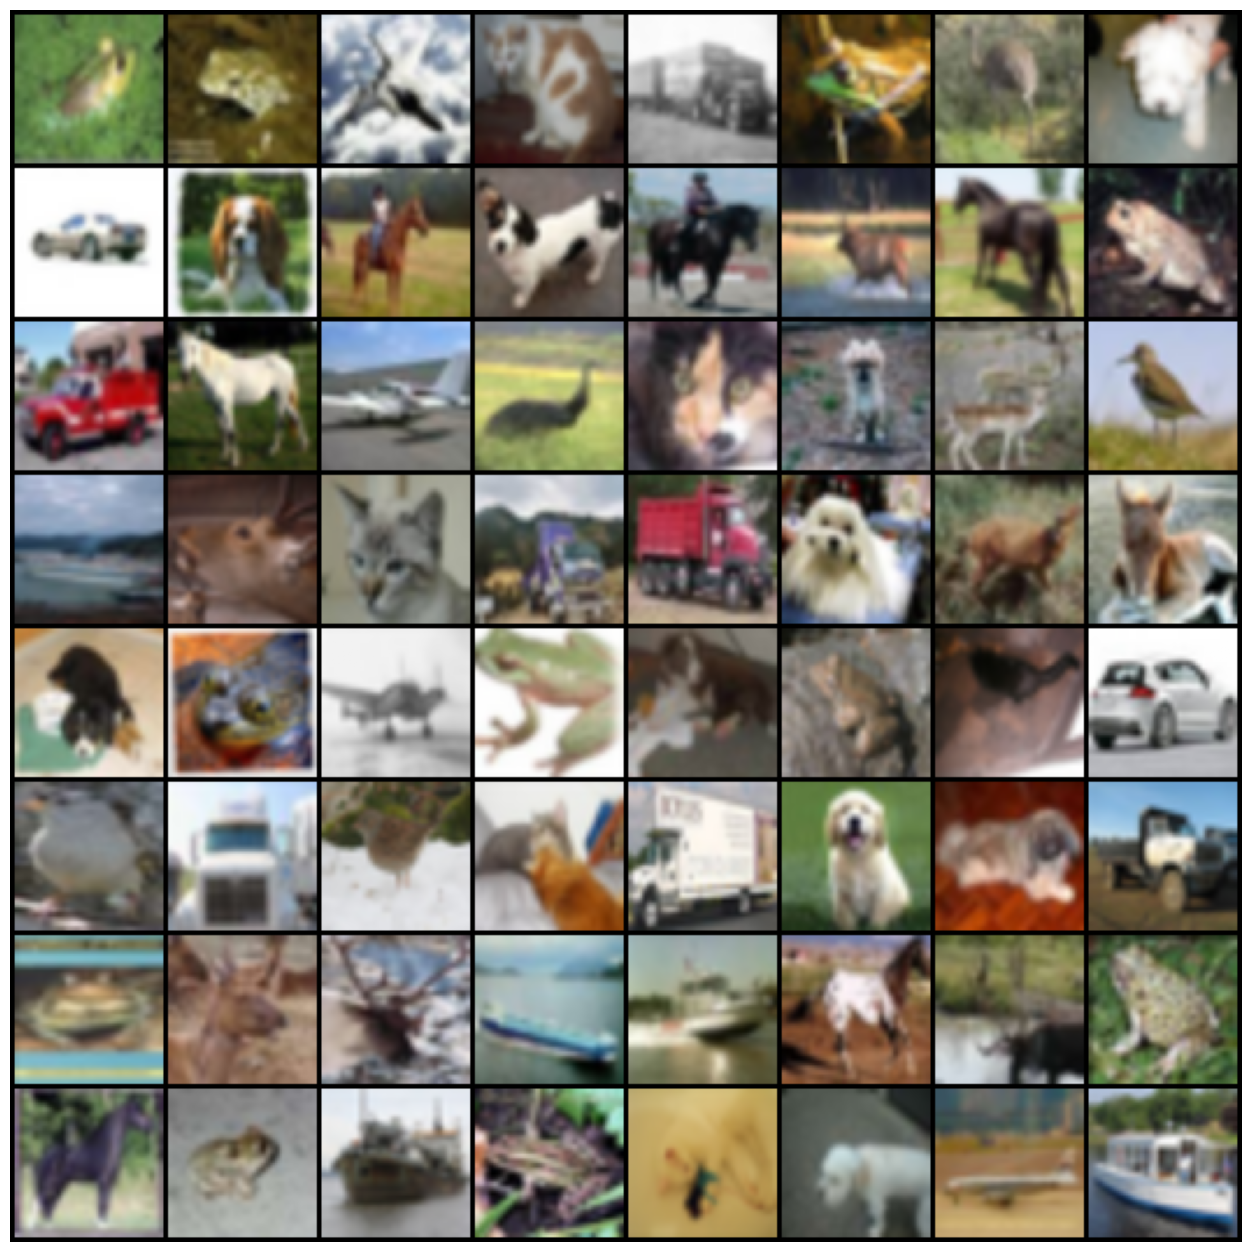

In [18]:
visualize_batch(train_dl)

In [28]:
import numpy as np
from tqdm import tqdm

def train_model(model, train_dataloader, val_dataloader, epochs, device, optimizer, criterion):
  train_loss = []
  val_loss = []
  train_accuracy = []
  val_accuracy = []

  for epoch in range(epochs):
    model.train()
    total_correct_train = 0
    total_train_samples = 0
    total_train_loss = 0.0

    print(f"Epoch {epoch + 1}/{epochs}")
    for batch in tqdm(train_dataloader, desc="Training", leave=False):
      images, labels = batch
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels.view(-1))
      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total_correct_train += (predicted == labels).sum().item()
      total_train_samples += labels.size(0)

    train_loss.append(total_train_loss / len(train_dataloader))
    train_accuracy.append(total_correct_train / total_train_samples)

    model.eval()
    total_correct_val = 0
    total_val_samples = 0
    total_val_loss = 0.0

    with torch.no_grad():
      for batch in tqdm(val_dataloader, desc="Validation", leave=False):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels.view(-1))

        total_val_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_correct_val += (predicted == labels).sum().item()
        total_val_samples += labels.size(0)

    val_loss.append(total_val_loss / len(val_dataloader))
    val_accuracy.append(total_correct_val / total_val_samples)

    print(f"Epoch: {epoch + 1}")
    print(f"Training Loss: {train_loss[-1]:.4f}")
    print(f"Training Accuracy: {train_accuracy[-1]:.4f}")
    print(f"Validation Loss: {val_loss[-1]:.4f}")
    print(f"Validation Accuracy: {val_accuracy[-1]:.4f}\n")

  return {
      "train_loss": train_loss,
      "val_loss": val_loss,
      "train_accuracy": train_accuracy,
      "val_accuracy": val_accuracy
  }


In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = F.cross_entropy

hist = train_model(model, train_dl, val_dl, epochs=10, device=DEVICE, optimizer=optimizer, criterion=criterion)

Epoch 1/10


Epoch: 1
Training Loss: 1.2826
Training Accuracy: 0.5415
Validation Loss: 1.2728
Validation Accuracy: 0.5445

Epoch 2/10


Epoch: 2
Training Loss: 1.1074
Training Accuracy: 0.6075
Validation Loss: 1.1033
Validation Accuracy: 0.6170

Epoch 3/10


Epoch: 3
Training Loss: 0.9870
Training Accuracy: 0.6520
Validation Loss: 1.0597
Validation Accuracy: 0.6232

Epoch 4/10


Epoch: 4
Training Loss: 0.8920
Training Accuracy: 0.6855
Validation Loss: 1.0289
Validation Accuracy: 0.6425

Epoch 5/10


Epoch: 5
Training Loss: 0.8177
Training Accuracy: 0.7148
Validation Loss: 0.9140
Validation Accuracy: 0.6757

Epoch 6/10


Epoch: 6
Training Loss: 0.7485
Training Accuracy: 0.7385
Validation Loss: 0.8324
Validation Accuracy: 0.7104

Epoch 7/10


Epoch: 7
Training Loss: 0.6899
Training Accuracy: 0.7617
Validation Loss: 0.9139
Validation Accuracy: 0.6966

Epoch 8/10


Epoch: 8
Training Loss: 0.6365
Training Accuracy: 0.7805
Validation Loss: 0.8050
Validation Accuracy: 0.7180

Epoch 9/10


Epoch: 9
Training Loss: 0.5868
Training Accuracy: 0.7998
Validation Loss: 0.8088
Validation Accuracy: 0.7268

Epoch 10/10


Epoch: 10
Training Loss: 0.5432
Training Accuracy: 0.8119
Validation Loss: 0.7688
Validation Accuracy: 0.7351



In [30]:
def visualize_metric(hist,metric):
  plt.plot(hist[f"train_{metric}"],"r*--",label=f"train_{metric}")
  plt.plot(hist[f"val_{metric}"],"b*--",label=f"val_{metric}")
  plt.legend()

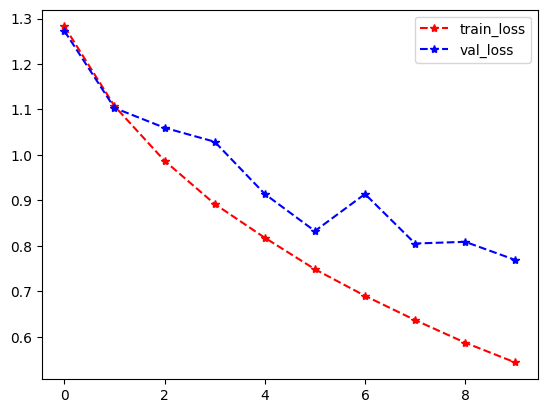

In [31]:
visualize_metric(hist,"loss")

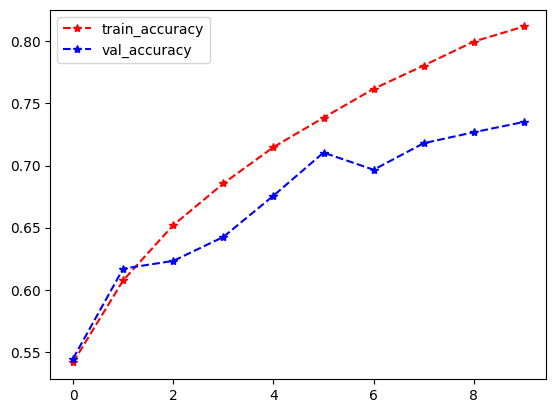

In [32]:
visualize_metric(hist,"accuracy")

### `The model shows no sign of under or overfitting and can be imporved by just training for more epochs...`